dataset  
- amazon review
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

- chABSA
https://github.com/chakki-works/chABSA-dataset


https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

In [45]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
%matplotlib inline
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [46]:
class TextCNN:

    def __init__(
      self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                pooled_outputs.append(pooled)


        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        

        with tf.name_scope("fc-1"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, 1024], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(self.h_pool_flat, W, b), name="fc-1-out")


        with tf.name_scope("dropout-1"):
            drop_1 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)


        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([1024,1024], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop_1, W, b), name="fc-2-out")
            
        with tf.name_scope("dropout-2"):
            drop_2 = tf.nn.dropout(fc_2_output, self.dropout_keep_prob)


        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(drop_2, W, b, name="output")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
            
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy") 

In [47]:
#positive_data_file = "data/amazon/book_pos.txt"
#negative_data_file = "data/amazon/book_neg.txt"
positive_data_file = "data/chABSA/pos.txt"
negative_data_file = "data/chABSA/neg.txt"

In [48]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char"):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        positive_examples = [s.strip() for s in positive_examples]
        negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y

In [49]:
%%notify
x_text, y = load_data_and_labels(positive_data_file, negative_data_file)

<IPython.core.display.Javascript object>

In [50]:
len(x_text)

2830

In [51]:
x_text[0]

' 当 連 結 会 計 年 度 の 世 界 経 済 は 、 米 国 を 中 心 に 景 気 は 概 ね 堅 調 に 推 移 し ま し た が 、 英 国 の e u 離 脱 問 題 に よ る 影 響 の ほ か 、 中 国 を は じ め と す る 新 興 国 経 済 の 減 速 懸 念 や 米 国 新 政 権 の 政 策 動 向 の 不 確 実 性 な ど 、 景 気 の 先 行 き は 不 透 明 な 状 況 が 続 き ま し た \n '

In [52]:
length_list = np.array([len(r)for r in x_text])

In [53]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,225
1,107
2,131
3,137
4,137


In [105]:
df.describe(percentiles=[0.5,0.75,0.8,0.9])

,length
count,2830.000000
mean,162.599293
std,77.631221
min,5.000000
50%,149.000000
75%,201.000000
80%,217.000000
90%,265.000000
max,805.000000


In [102]:
df.quantile(0.9)

length    265.0
Name: 0.9, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1221f9a20>]],
      dtype=object)

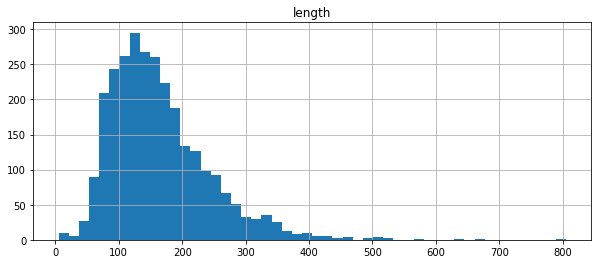

In [55]:
df.hist(bins=50,figsize=(10,4))

In [56]:
long_doc = True

In [57]:
if long_doc:
    x_text = [x[:2000] if len(x) > 2000 else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe()

,length
count,2830.000000
mean,162.599293
std,77.631221
min,5.000000
25%,107.000000
50%,149.000000
75%,201.000000
max,805.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c62c978>]],
      dtype=object)

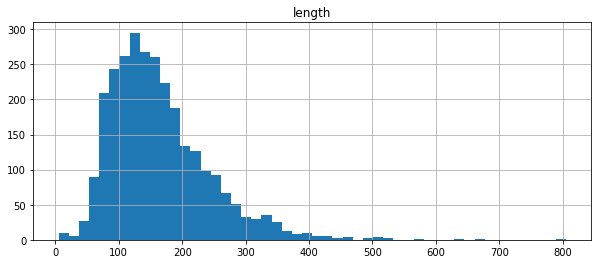

In [58]:
df.hist(bins=50,figsize=(10,4))

In [59]:
level = "char" #"word"

In [60]:
if level == "word":
    max_document_length = max([len(x.split(" ")) for x in x_text])
elif level == "char":
    max_document_length = max([len(x) for x in x_text])
print("max document length", max_document_length)

max document length 805


In [61]:
vocab_processor = preprocessing.VocabularyProcessor(max_document_length)

In [62]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

<IPython.core.display.Javascript object>

In [63]:
test_percentage = 0.1#0.0010

In [64]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 1517
Train/Test split: 2547/283


<IPython.core.display.Javascript object>

In [65]:
print(x_train.shape)

(2547, 805)


In [66]:
def save_pickle():
    chunk_size =  int(len(x_train)/10)
    print(chunk_size)
    for i in range(0, len(x_train), chunck_size):
        print(i)
        end = i+chunck_size
        if end < len(x_train):
            chunk = x_train[i:  end]
        else:
            chunk = x_train[i:]
            end = len(x_train)
        with open("data/x_train_{}.pkl".format(end), "wb") as f:
            pickle.dump(chunk, f, protocol = 4)

In [67]:
def load_x_train():
    all_size = 999000
    chunk_size = 99900
    x_train =[]
    for i in range(0, all_size, chunck_size):
        print(i)
        end = i+chunk_size
        if end > len(reviews):
            end = all_size
        with open("data/x_train_{}.pkl".format(end), "rb") as f:
            x_train += pickle.load(f)
        return x_train
#x_train = load_x_train()

In [68]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [69]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [70]:
embedding_size = 32     
filter_sizes = [2,3,4,5]    
num_filters=128               
dropout_keep_prob=0.5 
l2_reg_lambda=0.0       

In [71]:
TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)

In [94]:
timestamp = str(int(time.time()))
#timestamp = "1525609926"
prefix = ""
#out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp, prefix))
out_dir = os.path.join(os.path.curdir, "runs", timestamp, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/1526271055/



In [95]:
batch_size = 64                  
num_epochs = 20#200            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True

In [96]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        test_summary_op = tf.summary.merge([loss_summary, acc_summary])
        test_summary_dir = os.path.join(out_dir, "summaries", "test")
        test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def test_step(x_batch, y_batch, writer=None):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run([global_step, test_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                test_step(x_test, y_test, writer=test_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using 

2018-05-14T13:11:31.187044: step 70, loss 1.80864, acc 0.46875
2018-05-14T13:11:31.518569: step 71, loss 1.59018, acc 0.5625
2018-05-14T13:11:31.857794: step 72, loss 1.4546, acc 0.53125
2018-05-14T13:11:32.197292: step 73, loss 1.12823, acc 0.71875
2018-05-14T13:11:32.549874: step 74, loss 1.15161, acc 0.65625
2018-05-14T13:11:32.890185: step 75, loss 1.22194, acc 0.671875
2018-05-14T13:11:33.232213: step 76, loss 1.09945, acc 0.671875
2018-05-14T13:11:33.571958: step 77, loss 1.01891, acc 0.703125
2018-05-14T13:11:33.906641: step 78, loss 0.892965, acc 0.65625
2018-05-14T13:11:34.250388: step 79, loss 1.08629, acc 0.609375
2018-05-14T13:11:34.524914: step 80, loss 0.98826, acc 0.647059

Evaluation:
2018-05-14T13:11:35.149493: step 80, loss 0.56008, acc 0.717314

Saved model checkpoint to /Users/tamoto.yoshifumi/Workspace/Python/char_level_cnn/runs/1526271055/checkpoints/model-80

2018-05-14T13:11:35.675805: step 81, loss 1.36983, acc 0.453125
2018-05-14T13:11:36.089074: step 82, loss

2018-05-14T13:12:17.145530: step 181, loss 0.483708, acc 0.796875
2018-05-14T13:12:17.486463: step 182, loss 0.516477, acc 0.75
2018-05-14T13:12:17.836343: step 183, loss 0.571847, acc 0.765625
2018-05-14T13:12:18.205581: step 184, loss 0.534263, acc 0.671875
2018-05-14T13:12:18.556321: step 185, loss 0.387738, acc 0.8125
2018-05-14T13:12:18.896336: step 186, loss 0.471033, acc 0.796875
2018-05-14T13:12:19.288088: step 187, loss 0.485586, acc 0.71875
2018-05-14T13:12:19.720150: step 188, loss 0.496811, acc 0.765625
2018-05-14T13:12:20.129215: step 189, loss 0.50899, acc 0.796875
2018-05-14T13:12:20.611843: step 190, loss 0.451931, acc 0.75
2018-05-14T13:12:21.021570: step 191, loss 0.468328, acc 0.78125
2018-05-14T13:12:21.401931: step 192, loss 0.42376, acc 0.828125
2018-05-14T13:12:21.732735: step 193, loss 0.528886, acc 0.734375
2018-05-14T13:12:22.082146: step 194, loss 0.583652, acc 0.75
2018-05-14T13:12:22.480631: step 195, loss 0.53793, acc 0.703125
2018-05-14T13:12:22.816689: s

2018-05-14T13:13:01.333855: step 292, loss 0.288694, acc 0.890625
2018-05-14T13:13:01.701344: step 293, loss 0.436656, acc 0.8125
2018-05-14T13:13:02.037305: step 294, loss 0.311906, acc 0.859375
2018-05-14T13:13:02.383828: step 295, loss 0.372027, acc 0.828125
2018-05-14T13:13:02.790880: step 296, loss 0.370055, acc 0.828125
2018-05-14T13:13:03.177080: step 297, loss 0.366143, acc 0.84375
2018-05-14T13:13:03.525223: step 298, loss 0.749527, acc 0.765625
2018-05-14T13:13:03.873410: step 299, loss 0.392304, acc 0.796875
2018-05-14T13:13:04.225642: step 300, loss 0.492338, acc 0.75

Evaluation:
2018-05-14T13:13:04.802061: step 300, loss 0.422221, acc 0.816254

Saved model checkpoint to /Users/tamoto.yoshifumi/Workspace/Python/char_level_cnn/runs/1526271055/checkpoints/model-300

2018-05-14T13:13:05.474137: step 301, loss 0.428253, acc 0.75
2018-05-14T13:13:05.891130: step 302, loss 0.324788, acc 0.84375
2018-05-14T13:13:06.339149: step 303, loss 0.325984, acc 0.90625
2018-05-14T13:13:06.

2018-05-14T13:13:47.759277: step 401, loss 0.231518, acc 0.890625
2018-05-14T13:13:48.127168: step 402, loss 0.252986, acc 0.9375
2018-05-14T13:13:48.607824: step 403, loss 0.174823, acc 0.9375
2018-05-14T13:13:48.985921: step 404, loss 0.280952, acc 0.90625
2018-05-14T13:13:49.425774: step 405, loss 0.476631, acc 0.796875
2018-05-14T13:13:49.847585: step 406, loss 0.305765, acc 0.84375
2018-05-14T13:13:50.290387: step 407, loss 0.23577, acc 0.90625
2018-05-14T13:13:50.734726: step 408, loss 0.243668, acc 0.890625
2018-05-14T13:13:51.126617: step 409, loss 0.223384, acc 0.921875
2018-05-14T13:13:51.528172: step 410, loss 0.386394, acc 0.828125
2018-05-14T13:13:51.935417: step 411, loss 0.27293, acc 0.875
2018-05-14T13:13:52.306999: step 412, loss 0.217053, acc 0.9375
2018-05-14T13:13:52.653872: step 413, loss 0.403311, acc 0.796875
2018-05-14T13:13:53.009916: step 414, loss 0.238336, acc 0.90625
2018-05-14T13:13:53.376942: step 415, loss 0.326826, acc 0.890625
2018-05-14T13:13:53.70463

2018-05-14T13:14:33.124649: step 512, loss 0.230895, acc 0.90625
2018-05-14T13:14:33.564104: step 513, loss 0.166046, acc 0.921875
2018-05-14T13:14:33.917363: step 514, loss 0.265323, acc 0.90625
2018-05-14T13:14:34.248968: step 515, loss 0.310854, acc 0.90625
2018-05-14T13:14:34.574365: step 516, loss 0.398682, acc 0.84375
2018-05-14T13:14:34.908305: step 517, loss 0.239728, acc 0.90625
2018-05-14T13:14:35.251357: step 518, loss 0.230155, acc 0.921875
2018-05-14T13:14:35.677944: step 519, loss 0.284451, acc 0.859375
2018-05-14T13:14:35.946727: step 520, loss 0.104576, acc 0.941176

Evaluation:
2018-05-14T13:14:36.482458: step 520, loss 0.318005, acc 0.848057

Saved model checkpoint to /Users/tamoto.yoshifumi/Workspace/Python/char_level_cnn/runs/1526271055/checkpoints/model-520

2018-05-14T13:14:37.087334: step 521, loss 0.235562, acc 0.875
2018-05-14T13:14:37.534191: step 522, loss 0.149291, acc 0.953125
2018-05-14T13:14:37.992309: step 523, loss 0.230315, acc 0.875
2018-05-14T13:14:3

2018-05-14T13:15:15.496880: step 621, loss 0.236848, acc 0.921875
2018-05-14T13:15:15.894425: step 622, loss 0.177893, acc 0.90625
2018-05-14T13:15:16.247472: step 623, loss 0.227657, acc 0.890625
2018-05-14T13:15:16.673323: step 624, loss 0.119948, acc 0.9375
2018-05-14T13:15:17.178143: step 625, loss 0.114456, acc 0.9375
2018-05-14T13:15:17.623912: step 626, loss 0.240889, acc 0.859375
2018-05-14T13:15:18.099145: step 627, loss 0.0985414, acc 0.953125
2018-05-14T13:15:18.491371: step 628, loss 0.206886, acc 0.9375


KeyboardInterrupt: 

char level cnn 
- 1525408577  
- 1526189751   good

In [87]:
def check_neg_posi(text):
    text = [s.replace(" ", "").replace("", " ").lower() for s in [text]]
    x = np.array(list(vocab_processor.fit_transform(text)))
    feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
    feature_2 = sess.run(cnn.scores, feed_dict=feed_dict)
    print(feature_2[0])
    if np.argmax(feature_2[0]):
        print("positive")
    else:
        print("negative")

In [88]:
check_neg_posi("伸び率は増加傾向にありました。")

[-3.4666646  3.9447124]
positive


In [89]:
check_neg_posi("伸び率は減少傾向にありました。")

[ 2.8813882 -1.8911232]
negative


In [90]:
check_neg_posi("伸び率は加向にありました。")

[-0.9804301  1.8085191]
positive


In [91]:
check_neg_posi("伸び率は減向にありました。")

[ 2.6227853 -1.3544416]
negative


In [100]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path

In [101]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, latest_ckpt)

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]